### Political Polarization Calculations using BHPS 1995 data

In [1]:
import pandas as pd
import os, time
import numpy as np

In [2]:
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

In [3]:
df_residence = pd.read_csv("eindresp.csv")

C:\Users\Sidrcs\anaconda3\envs\PySAL\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (6,7,28,400,588,824,858,859,870,871,872,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,975,999,1001) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Interested variables for visualization
Look for <code>eindresp.csv</code> | Required variables are: (These are columns names and their corresponding interpretation) <ul><li><code>eopsocc</code> : "Private enterprise is the best way to solve Britain’s economic problems" (S1)</li> <li><code>eopsocd</code> : "Major public services and industries ought to be in state ownership" (S2)</li> <li><code>eopsoce</code> : "It is the government’s responsibility to provide a job for everyone who wants one" (S3)</li> <li><code>efiyr</code> : <b>Self-reported annual income</b> </li> <li><code>efetype</code> : <b>Educational qualification</b></li> <li><code>eplbornc_cc</code> : <b>Country of birth</b></li> <li><code>eage12</code> : <b>Age</b></li> <li><code>ejbstatt</code> : <b>Employment status</b></li> <li><code>eregion2</code> : <b>UK region name</b> </li></ul>

In [4]:
# Loading variables of interest from 1995 BHPS dataset into dataframe
df_residence = df_residence[["eopsocc","eopsocd","eopsoce","efiyr","efetype","eage12","ejbstatt","eregion2", "eplbornc_cc"]]

In [5]:
# Dropping rows if they donot have any spatial information
df_residence = df_residence[~df_residence["eregion2"].isin(["don't know", "inapplicable", "missing or wild", "refused"])]

In [6]:
# To view columns
df_residence.head()

,eopsocc,eopsocd,eopsoce,efiyr,efetype,eage12,ejbstatt,eregion2,eplbornc_cc
0,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,inapplicable,58.0,proxy and/or phone,London,proxy and/or phone
1,Agree,Disagree,Disagree,75532.59375,inapplicable,61.0,In paid employ,London,inapplicable
2,Agree,Agree,Disagree,514.2568359375,inapplicable,53.0,Self employed,London,inapplicable
3,Agree,"Not agree, disagree",Strongly disagree,0.0,inapplicable,16.0,"FT studt, school",London,australia
4,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,inapplicable,50.0,proxy and/or phone,London,proxy and/or phone


In [7]:
# create an empty dataframe
output_df = pd.DataFrame()

# Group the dataframe by county and calculate standard deviation of age : "aage12"
output_df["std_dev_age"] = df_residence.groupby("eregion2")["eage12"].agg("std")

# Group the dataframe by county and number of people born in UK : "aplbornc_cc"
output_df["born"] = df_residence.groupby("eregion2")["eplbornc_cc"]

# Assuming inapplicable as people born in UK to all others
def native_share(x):
    pop_count = list(x["born"][1])
    native_count = pop_count.count("inapplicable")/len(pop_count)
    return native_count

# calculating fraction of natives in each county
output_df["native_share"] = output_df.apply(lambda x: native_share(x), axis = 1)

# Dropping "born" groupby column
output_df = output_df.drop(columns = ["born"], axis = 1)

# Creating afetype_dict based on PDF from 1995 BHPS data
efetype_dict = {"Nursing school etc" : 1, "College of f educ" : 2, "Other trng establmnt" : 3, "Polytechnic" : 4, \
                "University" : 5, "None of the above" : 7, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy and/or phone" : -7, "refused" : -2}


# Create a new column "afetype_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["efetype_encoded"] = df_residence["efetype"].replace(efetype_dict)

# Group the dataframe by county and "afetype_encoded"
output_df["education"] = df_residence.groupby("eregion2")["efetype_encoded"]

# function to calculate dissimilarity in education
def dissimilarity_education(x):
    # loads tuple element into job
    job = x["education"][1]
    # loads frequency of each education type in county as list
    freq = list(job.value_counts())
    # calculates total number of groups
    s = len(freq)
    dissim_index = 0
    for i in freq:
        # formula of dissimilarity index
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

def region_name(x):
    return x["education"][0]

output_df["education_variability"] = output_df.apply(lambda x: dissimilarity_education(x), axis = 1)
output_df["region_name"] = output_df.apply(lambda x: region_name(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["education"], axis = 1)

# Creating ajbstatt_dict based on PDF from 1991 BHPS data
ejbstatt_dict = {"Self employed" : 1, "In paid employ" : 2, "Unemployed" : 3, "Retired" : 4, "Maternity leave" : 5, \
                    "Family care" : 6,  "FT studt, school" : 7, " LT sick, disabld" : 8, \
                    "Govt trng scheme" : 9, "Something else" : 10, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy" : -7, "refused" : -2}


# Create a new column "ajbstatt_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["ejbstatt_encoded"] = df_residence["ejbstatt"].replace(ejbstatt_dict)

# Group the dataframe by county and calculate the mean and standard deviation of the encoded values
output_df["job"] = df_residence.groupby("eregion2")["ejbstatt_encoded"]

# function to calculate dissimilarity in job
def dissimilarity_job(x):
    job = x["job"][1]
    freq = list(job.value_counts())
    s = len(freq)
    dissim_index = 0
    for i in freq:
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

# function to calculate fraction of employed people within each county
def frac_employed(x):
    job = list(x["job"][1])
    frac_emp = (job.count(2)/len(job))
    return frac_emp

output_df["job_variability"] = output_df.apply(lambda x: dissimilarity_job(x), axis = 1)
output_df ["frac_employed"] = output_df.apply(lambda x: frac_employed(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["job"], axis = 1)

# replacing all Not-A-Number cases to zero i.e., proxy values
df_residence["efiyr"] = df_residence["efiyr"].replace("proxy and/or phone",0)

# Group the dataframe by county and calculate median based on self-reported annual income: "afiyr"
output_df["median_income"] = df_residence.groupby("eregion2")["efiyr"].agg(["median"])

# convert "afiyr" column to float data type
df_residence["efiyr"] = df_residence["efiyr"].astype("float32")

# group incomes by county
output_df["income"] = df_residence.groupby("eregion2")["efiyr"]

def gini_index(x):
    data = list(x["income"][1])
    # sort the data in ascending order
    sorted_data = np.sort(data)
    # calculate the cumulative sum of the sorted data
    cumsum_data = np.cumsum(sorted_data)
    # calculate the Lorenz curve values
    lorenz_curve = cumsum_data / cumsum_data[-1]
    # calculate the area under the Lorenz curve
    area_lorenz_curve = np.trapz(lorenz_curve, dx=1/len(data))
    # calculate the Gini index
    gini_index = 1 - 2 * area_lorenz_curve
    return gini_index

output_df["gini_index"] = output_df.apply(lambda x : gini_index(x), axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["income"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index
eregion2,,,,,,,,
East Midlands,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445312,0.485968
East of England,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132812,0.497099
London,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353
North East,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352
North West,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123
Scotland,18.132051,0.934602,420.0,Scotland,420.0,0.475624,6681.736328,0.497527
South East,18.151452,0.946148,668.0,South East,668.0,0.504114,7912.114746,0.494032
South West,19.026620,0.940828,422.0,South West,422.0,0.455621,6339.334961,0.494527
Wales,18.734239,0.947262,246.0,Wales,246.0,0.399594,6077.859863,0.458942


In [10]:
# Define the dictionary to encode the "eopsocc" column which is Statement 1 (S1)
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
eopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsocc_encoded"] = df_residence["eopsocc"].replace(eopsocc_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['eopsocc_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S1"] = df_residence.groupby("eregion2")["eopsocc_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsocc_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsocc_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S1"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and eopsocc_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsocc_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S1"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1
eregion2,,,,,,,,,,,
East Midlands,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445312,0.485968,0.843213,0.726141,1.394025
East of England,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132812,0.497099,0.853691,0.725131,1.004499
London,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353,0.858060,0.761139,0.376180
North East,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352,0.818051,0.719794,1.236752
North West,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123,0.880076,0.776119,0.954488
Scotland,18.132051,0.934602,420.0,Scotland,420.0,0.475624,6681.736328,0.497527,0.874789,0.808540,0.540013
South East,18.151452,0.946148,668.0,South East,668.0,0.504114,7912.114746,0.494032,0.785931,0.677075,0.894840
South West,19.026620,0.940828,422.0,South West,422.0,0.455621,6339.334961,0.494527,0.854575,0.723179,2.122681
Wales,18.734239,0.947262,246.0,Wales,246.0,0.399594,6077.859863,0.458942,0.844509,0.803204,0.744511


In [11]:
# Define the dictionary to encode the "eopsocd" column which is Statement 2 (S2)
# S2: "Major public services and industries ought to be in state ownership."
eopsocd_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsocd_encoded"] = df_residence["eopsocd"].replace(eopsocd_dict)

#remove -3 valued rows from df_residence[eopsocd_encoded]
df_residence = df_residence[df_residence['eopsocd_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S2"] = df_residence.groupby("eregion2")["eopsocd_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsocd_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsocd_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S2"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and eopsocd_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsocd_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S2"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_12284\1532009655.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residence["eopsocd_encoded"] = df_residence["eopsocd"].replace(eopsocd_dict)


,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2
eregion2,,,,,,,,,,,,,,
East Midlands,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445312,0.485968,0.843213,0.726141,1.394025,1.008246,0.852113,1.213617
East of England,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132812,0.497099,0.853691,0.725131,1.004499,0.977064,0.828457,0.922243
London,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353,0.858060,0.761139,0.376180,0.984581,0.873897,0.883788
North East,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352,0.818051,0.719794,1.236752,0.978367,0.837270,1.336194
North West,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123,0.880076,0.776119,0.954488,1.038682,0.899288,1.155058
Scotland,18.132051,0.934602,420.0,Scotland,420.0,0.475624,6681.736328,0.497527,0.874789,0.808540,0.540013,0.962221,0.874471,0.955175
South East,18.151452,0.946148,668.0,South East,668.0,0.504114,7912.114746,0.494032,0.785931,0.677075,0.894840,0.919018,0.800664,0.520194
South West,19.026620,0.940828,422.0,South West,422.0,0.455621,6339.334961,0.494527,0.854575,0.723179,2.122681,1.007488,0.833784,2.341026
Wales,18.734239,0.947262,246.0,Wales,246.0,0.399594,6077.859863,0.458942,0.844509,0.803204,0.744511,1.055019,0.908879,1.656677


In [12]:
# Define the dictionary to encode the "eopsocd" column which is Statement 3 (S3)
# S3: "It is the government’s responsibility to provide a job for everyone who wants one."

eopsoce_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree": 0 , "Disagree":-1 , "Strongly disagree": -2,
                "don't know": -3, "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3, "Not agree, disagree": 0}

# Create a new column "eopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence["eopsoce_encoded"] = df_residence["eopsoce"].replace(eopsoce_dict)
df_residence = df_residence[df_residence["eopsoce_encoded"] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S3"] = df_residence.groupby("eregion2")["eopsoce_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("eregion2")["eopsoce_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("eregion2")["eopsoce_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S3"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and aopsocc_encoded values
output_df["dkp"] = df_residence.groupby("eregion2")["eopsoce_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S3"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
eregion2,,,,,,,,,,,,,,,,,
East Midlands,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445312,0.485968,0.843213,0.726141,1.394025,1.008246,0.852113,1.213617,1.131366,0.949153,1.878866
East of England,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132812,0.497099,0.853691,0.725131,1.004499,0.977064,0.828457,0.922243,1.089602,0.922667,2.041536
London,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353,0.858060,0.761139,0.376180,0.984581,0.873897,0.883788,1.188591,0.961929,3.195147
North East,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352,0.818051,0.719794,1.236752,0.978367,0.837270,1.336194,0.992494,0.950000,0.161722
North West,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123,0.880076,0.776119,0.954488,1.038682,0.899288,1.155058,1.091857,0.967280,1.398335
Scotland,18.132051,0.934602,420.0,Scotland,420.0,0.475624,6681.736328,0.497527,0.874789,0.808540,0.540013,0.962221,0.874471,0.955175,1.139900,0.988701,1.264510
South East,18.151452,0.946148,668.0,South East,668.0,0.504114,7912.114746,0.494032,0.785931,0.677075,0.894840,0.919018,0.800664,0.520194,1.080334,0.919234,1.218511
South West,19.026620,0.940828,422.0,South West,422.0,0.455621,6339.334961,0.494527,0.854575,0.723179,2.122681,1.007488,0.833784,2.341026,1.048865,0.900950,1.723318
Wales,18.734239,0.947262,246.0,Wales,246.0,0.399594,6077.859863,0.458942,0.844509,0.803204,0.744511,1.055019,0.908879,1.656677,1.016852,1.011737,1.629828


In [13]:
output_df.reset_index(drop=True, inplace=True)
output_df

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445312,0.485968,0.843213,0.726141,1.394025,1.008246,0.852113,1.213617,1.131366,0.949153,1.878866
1,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132812,0.497099,0.853691,0.725131,1.004499,0.977064,0.828457,0.922243,1.089602,0.922667,2.041536
2,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353,0.858060,0.761139,0.376180,0.984581,0.873897,0.883788,1.188591,0.961929,3.195147
3,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352,0.818051,0.719794,1.236752,0.978367,0.837270,1.336194,0.992494,0.950000,0.161722
4,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123,0.880076,0.776119,0.954488,1.038682,0.899288,1.155058,1.091857,0.967280,1.398335
5,18.132051,0.934602,420.0,Scotland,420.0,0.475624,6681.736328,0.497527,0.874789,0.808540,0.540013,0.962221,0.874471,0.955175,1.139900,0.988701,1.264510
6,18.151452,0.946148,668.0,South East,668.0,0.504114,7912.114746,0.494032,0.785931,0.677075,0.894840,0.919018,0.800664,0.520194,1.080334,0.919234,1.218511
7,19.026620,0.940828,422.0,South West,422.0,0.455621,6339.334961,0.494527,0.854575,0.723179,2.122681,1.007488,0.833784,2.341026,1.048865,0.900950,1.723318
8,18.734239,0.947262,246.0,Wales,246.0,0.399594,6077.859863,0.458942,0.844509,0.803204,0.744511,1.055019,0.908879,1.656677,1.016852,1.011737,1.629828
9,18.253225,0.966460,402.0,West Midlands,402.0,0.475776,6500.000000,0.484510,0.855368,0.724658,1.605215,0.997036,0.846797,0.664775,1.051652,0.914566,1.975061


In [16]:
corr_df = output_df.corr()
corr_df.to_csv("correlation_1995.csv")
corr_df

,std_dev_age,native_share,education_variability,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
std_dev_age,1.000000,0.309882,-0.307354,-0.307354,-0.618452,-0.724673,-0.584971,-0.094633,-0.104803,0.609249,0.187688,-0.054918,0.497970,-0.536514,-0.157968,-0.390700
native_share,0.309882,1.000000,-0.222050,-0.222050,-0.024734,-0.279276,-0.580744,-0.325342,-0.343333,0.237991,-0.219311,-0.245507,-0.366020,-0.545106,-0.326833,-0.323262
education_variability,-0.307354,-0.222050,1.000000,1.000000,0.674597,0.594852,0.644228,-0.120302,-0.327348,-0.113992,-0.347498,-0.302108,-0.409191,0.471159,-0.356411,0.216993
job_variability,-0.307354,-0.222050,1.000000,1.000000,0.674597,0.594852,0.644228,-0.120302,-0.327348,-0.113992,-0.347498,-0.302108,-0.409191,0.471159,-0.356411,0.216993
frac_employed,-0.618452,-0.024734,0.674597,0.674597,1.000000,0.709052,0.609593,-0.177187,-0.483383,-0.130107,-0.579019,-0.551216,-0.560277,0.431227,-0.502926,0.081550
median_income,-0.724673,-0.279276,0.594852,0.594852,0.709052,1.000000,0.727797,-0.115976,-0.271587,-0.487426,-0.333356,-0.271385,-0.469441,0.593676,-0.190415,0.479937
gini_index,-0.584971,-0.580744,0.644228,0.644228,0.609593,0.727797,1.000000,0.413999,0.004106,-0.192891,-0.040742,-0.018309,-0.142961,0.820279,-0.188653,0.669790
Lindqvist_Ostling_S1,-0.094633,-0.325342,-0.120302,-0.120302,-0.177187,-0.115976,0.413999,1.000000,0.682017,-0.007352,0.645816,0.688884,0.342481,0.330882,0.347927,0.341477
Abramowitz_Saunders_S1,-0.104803,-0.343333,-0.327348,-0.327348,-0.483383,-0.271587,0.004106,0.682017,1.000000,-0.489070,0.458312,0.899910,0.204019,0.203891,0.850827,0.129713
Duca_Saving_S1,0.609249,0.237991,-0.113992,-0.113992,-0.130107,-0.487426,-0.192891,-0.007352,-0.489070,1.000000,0.218566,-0.370005,0.525753,-0.483497,-0.651916,-0.197580


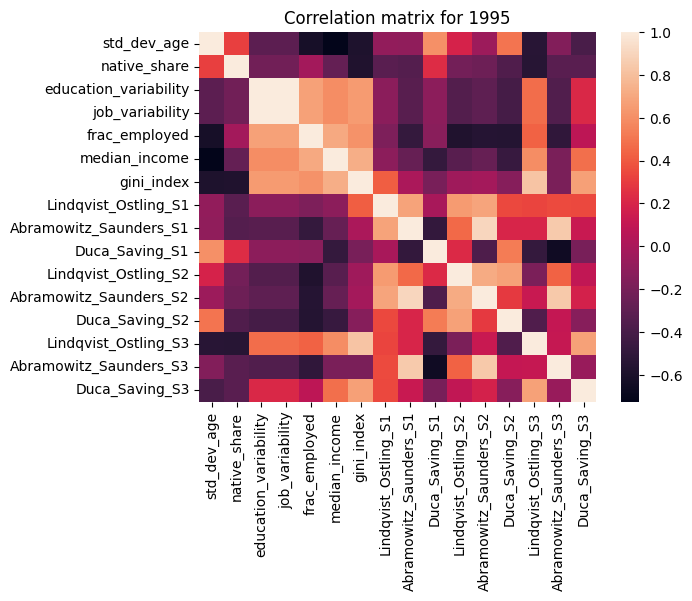

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = output_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation matrix for 1995")
plt.show()

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 1995')

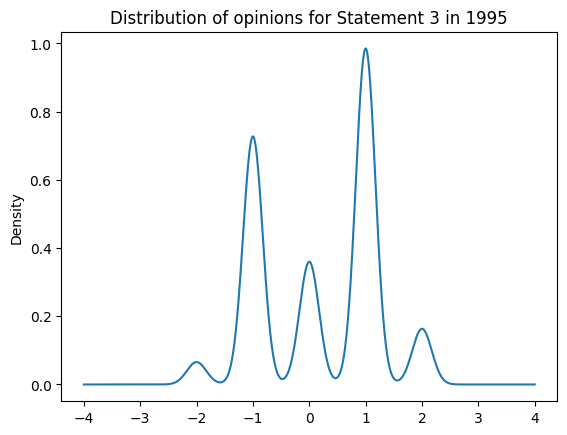

In [18]:
df_residence["eopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 1995")

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 1995')

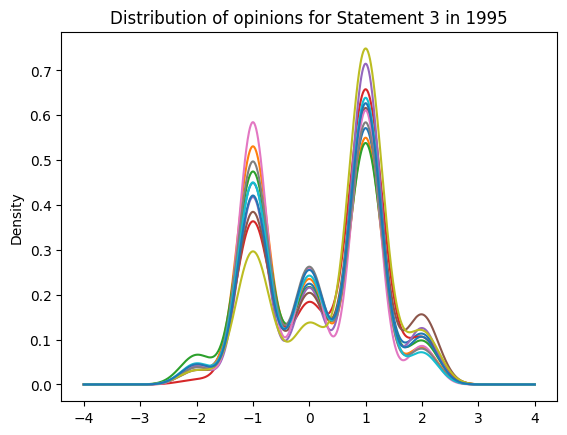

In [19]:
df_residence.groupby("eregion2")["eopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 1995")

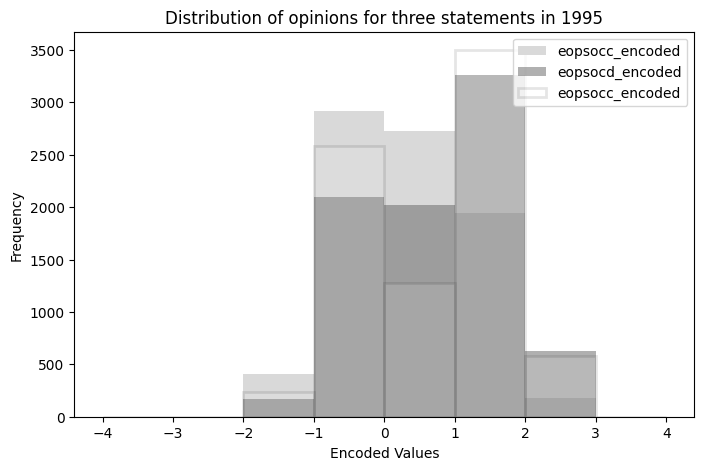

In [21]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(df_residence["eopsocc_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#d9d9d9')
ax.hist(df_residence["eopsocd_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#636363', alpha = 0.5)
ax.hist(df_residence["eopsoce_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='white', alpha = 0.1, edgecolor='black', linewidth = 2)

# set title and axis labels
ax.set_title('Distribution of opinions for three statements in 1995')
ax.set_xlabel('Encoded Values')
ax.set_ylabel('Frequency')

# add a legend
ax.legend(['eopsocc_encoded', 'eopsocd_encoded', 'eopsocc_encoded'], loc='upper right')

plt.show()

In [12]:
output_df.to_csv("polarization1995_data.csv")